# **Importing libraries**

In [17]:
import numpy as np
import pandas as pd 
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import time
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\meera\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meera\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Loading DataSet**

In [18]:
# Load the dataset into a DataFrame
data = pd.read_csv('data_hierarchial_classif.csv')

df = data[['Title', 'Text', 'Cat1', 'Cat2', 'Cat3']]

df.isna().sum() #5 NA values in 'Title' column

df['Title']=df['Title'].fillna("") 

C:\Users\meera\AppData\Local\Temp/ipykernel_9016/3398418076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Title']=df['Title'].fillna("")


# **Preprocessing feature columns**

In [19]:
# Define data pre-processing function

def preprocess_text(text):
    # Convert text to lowercase and remove special characters
    lower_case = text.lower().strip().replace('\n', ' ').replace('\r', ' ')
    alphabetic = re.sub(r'[^a-zA-Z\']', ' ', lower_case)
    without_link = re.sub(r'http\S+', '', alphabetic)
    
    # Tokenize text
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(without_link)
    
    # Remove stopwords
    stop = set(stopwords.words('english')) - set(["my", "haven't", "aren't", "can", "no", "why", "through", "herself", "she", "he", "himself", "you", "you're", "myself", "not", "here", "some", "do", "does", "did", "will", "don't", "doesn't", "didn't", "won't", "should", "should've", "couldn't", "mightn't", "mustn't", "shouldn't", "hadn't", "wasn't", "wouldn't"])
    filtered_tokens = [word for word in tokens if word not in stop]
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    # Join tokens back into text
    processed_text = " ".join(lemmatized_text)
    
    return processed_text

# Apply data pre-processing to 'Text' and 'Title' columns
df['Text_Updated'] = df['Text'].apply(preprocess_text)
df['Title_Updated'] = df['Title'].apply(preprocess_text)
df['Title_Text_Combined'] = df['Title_Updated'] + ' ' + df['Text_Updated']

C:\Users\meera\AppData\Local\Temp/ipykernel_9016/2857222149.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text_Updated'] = df['Text'].apply(preprocess_text)
C:\Users\meera\AppData\Local\Temp/ipykernel_9016/2857222149.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Title_Updated'] = df['Title'].apply(preprocess_text)


# **Visualizing Features**

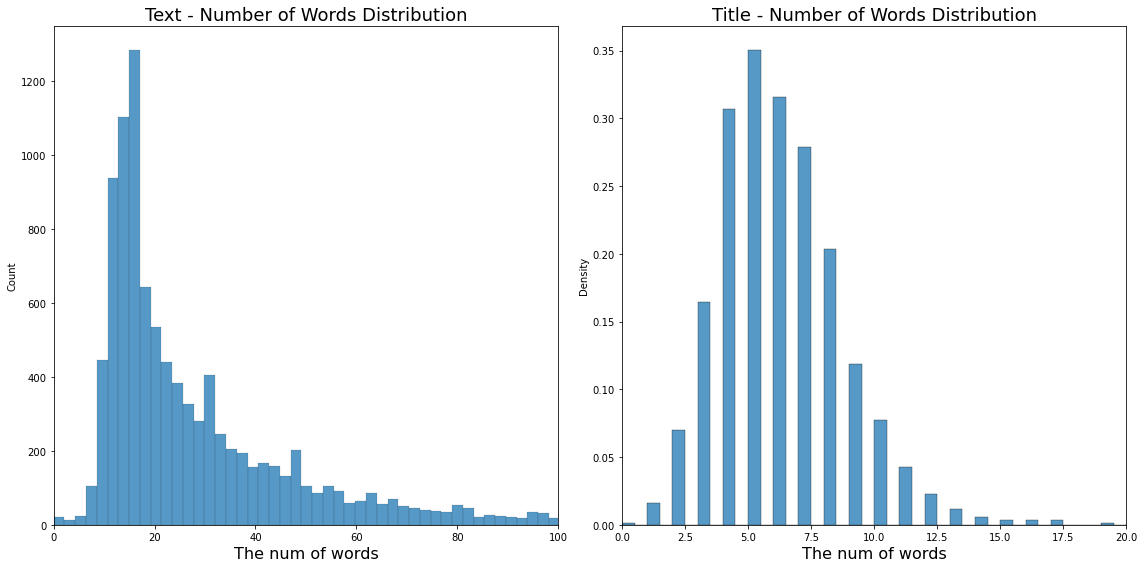

In [20]:
df['count_text'] = df['Text_Updated'].apply(lambda x: len(x.split()))
df['count_title'] = df['Title_Updated'].apply(lambda x: len(x.split()))

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot for Text
sns.histplot(df['count_text'], ax=axs[0])
axs[0].set_xlim(0, 100)
axs[0].set_xlabel('The num of words', fontsize=16)
axs[0].set_title('Text - Number of Words Distribution', fontsize=18)

# Plot for Title
sns.histplot(df['count_title'], ax=axs[1], stat='density', binwidth=0.5)
axs[1].set_xlim(0, 20)
axs[1].set_xlabel('The num of words', fontsize=16)
axs[1].set_title('Title - Number of Words Distribution', fontsize=18)

plt.tight_layout()
plt.show()

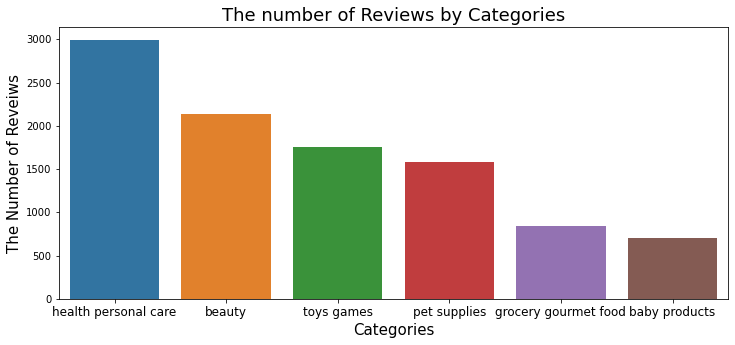

In [21]:
# checking category 1 frequency for the entire data
# Note - For Category 2 & 3 - the frequency plot was not visually appealing since no. of categories is high

category_count = df['Cat1'].value_counts()

categories = category_count.index

fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )
    
plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of Reveiws', size= 15)

plt.xticks(size = 12)

plt.title("The number of Reviews by Categories" , size = 18)

plt.show()

# **Feature selection using ML models**

In [22]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define pipelines for Logistic Regression and Linear SVC
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=50000, min_df=1)),
    ('logistic', LogisticRegression(n_jobs=-1, solver='lbfgs', multi_class='multinomial', random_state=42, max_iter=500))
])

pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=50000, min_df=1)),
    ('svc', LinearSVC(class_weight='balanced', random_state=42))
])

# Define the feature and target columns
feature_columns = ['Text_Updated', 'Title_Updated', 'Title_Text_Combined']
target_columns = ['Cat1', 'Cat2', 'Cat3']

# Initialize an empty DataFrame to store results
results_combined_df = pd.DataFrame(columns=['Category', 'Feature', 'Model', 'Accuracy', 'F1-score'])

# Iterate over each feature column
for feature_column in feature_columns:
    print(f"Analyzing performance for {feature_column}:")
    
    # Iterate over each pipeline
    for pipeline_name, pipeline in [('Logistic Regression', pipeline_lr), ('Linear SVC', pipeline_svc)]:
        print(f"Evaluating model: {pipeline_name}")
        
        # Initialize an empty DataFrame to store results for the current model and feature column
        results_df = pd.DataFrame(columns=['Category', 'Feature', 'Model', 'Accuracy', 'F1-score'])
        
        # Iterate over each target column
        for target_column in target_columns:
            print(f"Analyzing performance for {target_column} using {pipeline_name}:")
            
            # Split the data into features and target labels
            X_train = train_df[feature_column]
            X_test = test_df[feature_column]
            y_train = train_df[target_column]
            y_test = test_df[target_column]

            # Train the model
            pipeline.fit(X_train, y_train)

            # Make predictions
            predictions = pipeline.predict(X_test)

            # Calculate evaluation metrics
            accuracy = accuracy_score(y_test, predictions)
            f1 = f1_score(y_test, predictions, average='weighted')

            # Append results to the current model's results DataFrame
            results_df = results_df.append({'Category': target_column, 'Feature': feature_column, 'Model': pipeline_name, 'Accuracy': accuracy, 'F1-score': f1}, ignore_index=True)
        
        # Append results for the current model and feature column to the combined DataFrame
        results_combined_df = pd.concat([results_combined_df, results_df], ignore_index=True)
        
        # Print results for the current model and feature column
        print(results_df)
        print('-' * 50)

# Display combined results
print("Combined Results:")
display(results_combined_df)

Analyzing performance for Text_Updated:
Evaluating model: Logistic Regression
Analyzing performance for Cat1 using Logistic Regression:
Analyzing performance for Cat2 using Logistic Regression:
Analyzing performance for Cat3 using Logistic Regression:
  Category       Feature                Model  Accuracy  F1-score
0     Cat1  Text_Updated  Logistic Regression     0.771  0.767088
1     Cat2  Text_Updated  Logistic Regression     0.509  0.461669
2     Cat3  Text_Updated  Logistic Regression     0.335  0.285983
--------------------------------------------------
Evaluating model: Linear SVC
Analyzing performance for Cat1 using Linear SVC:
Analyzing performance for Cat2 using Linear SVC:
Analyzing performance for Cat3 using Linear SVC:
  Category       Feature       Model  Accuracy  F1-score
0     Cat1  Text_Updated  Linear SVC    0.7780  0.778235
1     Cat2  Text_Updated  Linear SVC    0.5760  0.576305
2     Cat3  Text_Updated  Linear SVC    0.4175  0.424120
-----------------------------

,Category,Feature,Model,Accuracy,F1-score
0,Cat1,Text_Updated,Logistic Regression,0.7710,0.767088
1,Cat2,Text_Updated,Logistic Regression,0.5090,0.461669
2,Cat3,Text_Updated,Logistic Regression,0.3350,0.285983
3,Cat1,Text_Updated,Linear SVC,0.7780,0.778235
4,Cat2,Text_Updated,Linear SVC,0.5760,0.576305
5,Cat3,Text_Updated,Linear SVC,0.4175,0.424120
6,Cat1,Title_Updated,Logistic Regression,0.8970,0.896788
7,Cat2,Title_Updated,Logistic Regression,0.7605,0.746068
8,Cat3,Title_Updated,Logistic Regression,0.5990,0.575244
9,Cat1,Title_Updated,Linear SVC,0.9230,0.922969


# **Evaluating ML model performance on best feature**

In [23]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define the models
models = {
    'Multinomial NB': MultinomialNB(),
    'Random Forest':  RandomForestClassifier(n_jobs=-1, n_estimators=500, class_weight='balanced', random_state=42),
#     'Gradient Boost': GradientBoostingClassifier(), #Computationally expensive - For Cat3 - runtime - 1hr
    'Logistic Regression': LogisticRegression(n_jobs=-1, solver='lbfgs', multi_class='multinomial', random_state=42, max_iter=500),
    'Support Vector Machine': LinearSVC(class_weight='balanced', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, weights='distance') #Not yielding good results
}

# Define the categories
categories = ['Cat1', 'Cat2', 'Cat3']

# Initialize an empty dataframe to store results
results_df = pd.DataFrame(columns=['Model', 'Category', 'Accuracy', 'F1-score', 'Precision', 'Recall'])

# Evaluate each model for each category
for model_name, model in models.items():
    for category in categories:
        # Define the pipeline
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000, min_df=2)),
            ('model', model)
        ])
        
        start_time = time.time()  # Record start time

        # Train the model
        pipeline.fit(train_df['Title_Updated'], train_df[category])

        end_time = time.time()  # Record end time
        runtime = end_time - start_time  # Calculate runtime

        # Convert runtime to minutes and seconds
        minutes = int(runtime // 60)
        seconds = int(runtime % 60)

        print(f"Model: {model_name}, Category: {category}, Runtime: {minutes} min {seconds} sec")

        # Make predictions
        predictions = pipeline.predict(test_df['Title_Updated'])

        # Calculate evaluation metrics
        accuracy = accuracy_score(test_df[category], predictions)
        f1 = f1_score(test_df[category], predictions, average='weighted')
        precision = precision_score(test_df[category], predictions, average='weighted')
        recall = recall_score(test_df[category], predictions, average='weighted')

        # Append results to dataframe
        results_df = results_df.append({'Model': model_name, 'Category': category, 
                                        'Accuracy': accuracy, 'F1-score': f1, 
                                        'Precision': precision, 'Recall': recall}, 
                                        ignore_index=True)

display(results_df)

Model: Multinomial NB, Category: Cat1, Runtime: 0 min 0 sec
Model: Multinomial NB, Category: Cat2, Runtime: 0 min 0 sec


C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Multinomial NB, Category: Cat3, Runtime: 0 min 0 sec


C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Random Forest, Category: Cat1, Runtime: 0 min 39 sec
Model: Random Forest, Category: Cat2, Runtime: 0 min 54 sec


C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Random Forest, Category: Cat3, Runtime: 2 min 13 sec


C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Logistic Regression, Category: Cat1, Runtime: 0 min 27 sec
Model: Logistic Regression, Category: Cat2, Runtime: 0 min 23 sec


C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Logistic Regression, Category: Cat3, Runtime: 1 min 18 sec


C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Support Vector Machine, Category: Cat1, Runtime: 0 min 0 sec
Model: Support Vector Machine, Category: Cat2, Runtime: 0 min 1 sec


C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Support Vector Machine, Category: Cat3, Runtime: 0 min 5 sec


C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: K-Nearest Neighbors, Category: Cat1, Runtime: 0 min 0 sec
Model: K-Nearest Neighbors, Category: Cat2, Runtime: 0 min 0 sec


C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: K-Nearest Neighbors, Category: Cat3, Runtime: 0 min 0 sec


C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Category,Accuracy,F1-score,Precision,Recall
0,Multinomial NB,Cat1,0.8835,0.882646,0.890294,0.8835
1,Multinomial NB,Cat2,0.6510,0.615189,0.711288,0.6510
2,Multinomial NB,Cat3,0.4345,0.400919,0.521512,0.4345
3,Random Forest,Cat1,0.8775,0.877818,0.881199,0.8775
4,Random Forest,Cat2,0.8015,0.800200,0.812578,0.8015
5,Random Forest,Cat3,0.7575,0.752402,0.775246,0.7575
6,Logistic Regression,Cat1,0.8875,0.887323,0.892952,0.8875
7,Logistic Regression,Cat2,0.7555,0.741138,0.780298,0.7555
8,Logistic Regression,Cat3,0.6070,0.582192,0.638146,0.6070
9,Support Vector Machine,Cat1,0.9110,0.910953,0.911460,0.9110


# **Predicting using best feature & best ML model and saving results**

In [16]:
# Maintain the same train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Find the best model for each category based on the F1-score
best_models = {}
trained_models = {}

for category in categories:
    best_model_idx = results_df[results_df['Category'] == category]['F1-score'].idxmax()
    best_model = results_df.loc[best_model_idx]['Model']
    best_models[category] = models[best_model]
    print(f"Best model for {category}: {best_model}")

    # Train each best model on the entire training dataset and make predictions
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, min_df=2)),
        ('model', best_models[category])
    ])
    pipeline.fit(train_df['Title_Updated'], train_df[category])
    trained_models[category] = pipeline

    # Make predictions on the test dataset
    predictions = pipeline.predict(test_df['Title_Updated'])

    # Print classification report for each category
    print(f"Classification report for {category}:")
    print(classification_report(test_df[category], predictions))

    # Save predictions to a CSV file
    predictions_df = pd.DataFrame({
        'Title_Updated': test_df['Title_Updated'],
        f'{category}_Original': test_df[category],
        f'{category}_Predicted': predictions
    })
    predictions_df.to_csv(f'{category}_predictions.csv', index=False)

    print()

Best model for Cat1: Support Vector Machine
Classification report for Cat1:
                      precision    recall  f1-score   support

       baby products       0.87      0.90      0.89       124
              beauty       0.92      0.91      0.92       425
grocery gourmet food       0.87      0.87      0.87       167
health personal care       0.92      0.89      0.90       624
        pet supplies       0.94      0.96      0.95       303
          toys games       0.89      0.94      0.91       357

            accuracy                           0.91      2000
           macro avg       0.90      0.91      0.91      2000
        weighted avg       0.91      0.91      0.91      2000


Best model for Cat2: Support Vector Machine
Classification report for Cat2:
                                  precision    recall  f1-score   support

              action toy figures       0.67      0.72      0.69        25
                     arts crafts       0.67      0.64      0.65        22
 

C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_cla

Classification report for Cat3:


C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meera\anaconda3\lib\site-packages\sklearn\metrics\_cla

                                    precision    recall  f1-score   support

                       accessories       0.75      0.43      0.55         7
                action toy figures       0.00      0.00      0.00         1
     activity centers entertainers       1.00      1.00      1.00         4
             activity play centers       0.00      0.00      0.00         0
                  adult toys games       0.90      0.60      0.72        15
                    air fresheners       1.00      1.00      1.00         1
                           allergy       1.00      0.80      0.89         5
              alternative medicine       0.59      0.62      0.61        16
                   animals figures       0.74      0.83      0.78        35
               apparel accessories       1.00      0.57      0.73         7
                     aprons smocks       0.00      0.00      0.00         0
                    aquarium d cor       0.50      0.67      0.57         3
           